This notebook contains code to infer the distribution of selection coefficients for different functional categories

In [13]:
%pylab inline
import glob
import os
import numpy as np
import sys
import seaborn as sns
sys.path.append("/storage/BonnieH/selection_project/helper_functions")
from Joint_method_functions import *
import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

PLOTDIR = 'pdfs-round1'
PREFIX = 'Figure3-'
RESFOLDER = '/gymreklab-tscc/bonnieh/joint_method/results_top_x'

Populating the interactive namespace from numpy and matplotlib


In [16]:
# PLot cdf of gamma distribution posterior estimates for real data

def main():
    print('Running main')
    
    folder = 'func_categ_analysis'
    fig_num = 0
    pers = [3] 
    #color_list = ['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9','b','k']
    color_list = ['red','orange','lawngreen','forestgreen','turquoise','blue','purple','brown','slategray','yellow','gold']
    
    '''
    motif_dic = {}
    motif_dic[2] = ['AC','AG','AT']
    motif_dic[3] = ['ACC','AGG','AGC','CCG','AAG','AAC','ATC','AAT']
    motif_dic[4] = ['AAGG','AAAT','ATCC','AATC','AAAC','AATG','ACAT','AGAT','AAAG']
    '''
    categories_list = [7,8,9,10,11,12]
    
    func_dic = {}
    func_dic[7] = 'Coding'
    func_dic[8] = 'Intron'
    func_dic[9] = "5'UTR"
    func_dic[10] = "3'UTR"
    func_dic[11] = "Promoter"
    func_dic[12] = "Intergenic"
    subplots_dic = {}
    subplots_dic[2] = [(3,4,1),(3,4,2),(3,4,3),(3,4,4),(3,4,5),(3,4,6),(3,4,7),(3,4,8),(3,4,10),(3,4,11)]
    subplots_dic[3] = [(3,3,1),(3,3,2),(3,3,3),(3,3,4),(3,3,5),(3,3,6),(3,3,7),(3,3,8),(3,3,9)]
    subplots_dic[4] = [(2,2,1),(2,2,2),(2,2,3),(2,2,4)]
    
    opt_dic = {}
    opt_dic[2] = range(11,21,1) 
    opt_dic[3] = range(5,14,1)
    opt_dic[4] = range(7,11,1)
    
    gamma_dic = {}
    for elem in categories_list:
        gamma_dic[elem] = []
    
    color_dic_motif={}
    
    for per in pers:
        i = -1
        for category in categories_list:
            i = i + 1
            color_dic_motif[category] = color_list[i]
    
    color_dic_opt={}
    for per in pers:
        i = -1
        for opt in opt_dic[per]:
            i = i + 1
            color_dic_opt[(per, opt)] = color_list[i]
            
    # Plot motifs (sep graph for each opt allele)
    for per in pers:
        opt_alleles = opt_dic[per]
        print('Period %d'%(per))
        
        index = -1
        for opt in opt_alleles:
            opt_string = str(opt)
            if opt < 10:
                opt_string = '0' + opt_string
            #file_list = glob.glob('./results/results/%s/per_%d_*opt_%s.txt'%(folder, per, opt_string))
            #file_list = glob.glob('/gymreklab-tscc/bonnieh/heatmap/results_bin_agnostic/%s/per_%d_*opt_%s.txt'%(folder, per, opt_string))
            file_list = glob.glob('%s/%s/per_%d_*_opt_%s.txt'%(RESFOLDER, folder, per, opt_string))
            file_list.sort() 
            
            base_plot = ''
            
            for filename in file_list:
                results_file = open(filename, 'r')
                lines = results_file.readlines()
                line = lines[4]
                info = line.strip().split(': ')
                num_acc = int(info[1])
                line = lines[1]
                info = line.strip().split(': ')
                #num_loci = info[1]
                #num_loci = num_loci.strip().split(' ')
                #num_loci = int(num_loci[0])
                # Use actual num loci
                num_loci = int(info[2])
                
                if num_acc > 0: # and num_loci >= 10:

                    line = lines[2]
                    info = line.strip().split(': ')
                    column = info[1]
                    column = column.strip().split(' ')
                    column = int(column[0])
                    opt_allele = int(info[3])
                    
                    if column != 'H':
                        line = lines[6]
                        info = line.strip().split(',')
                        k = float(info[0])
                        theta = float(info[1])
                        
                        gamma_dic[column].append((k, theta, num_loci, opt))

    cum_dic = {}
    num_loci_dic = {}
    for cat in categories_list:
        num_loci_dic[cat] = [0] *  len(opt_dic[pers[0]])
    for cat in categories_list:
        weighted_list = gamma_dic[cat]
        
        s = [] # List of s values drawn from gamma distribution
                        
        for opt in weighted_list:
            num_sims = opt[2]
            k = opt[0]
            theta = opt[1]
            opt_allele = opt[3]
            
            num_loci_dic[cat][opt_allele-opt_dic[pers[0]][0]] = num_sims
                            
            for i in range (0, num_sims):
                s_val = np.random.gamma(k, theta)
                if s_val > 0.1:
                    s_val = 0.1

                s.append(s_val)

        bins_list = [0]
        exponents = [10**-5, 10**-4, 10**-3, 10**-2]
        for j in exponents:
            for i in np.arange(1,10,0.01):
                bins_list.append(i*j)

        bins_list.append(0.1)
        bins_list.append(1)

        values, base = np.histogram(s, bins=bins_list)# [0,10**-5,10**-4,10**-3,10**-2,10**-1,1]#[0,10**-5,10**-4,10**-3,10**-2,10**-1,1]
                        
        cumulative = list(np.cumsum(values))
        maximum = max(cumulative)
        cumulative_scaled = []
        for elem in cumulative:
            elem = elem/maximum
            cumulative_scaled.append(elem)
                       
        cum_dic[cat] = cumulative_scaled
        base_plot = base
                          
    # Plot CDF
            
    index = index + 1
    fig_num = 1
    fig = plt.figure(fig_num)
    for elem in cum_dic:
                
        plt.plot(base_plot[:-1], cum_dic[elem], label = func_dic[elem] + ' Joint', color=color_dic_motif[elem], linewidth = 3, ls='dashed') # (' + str(elem[2]) + ' loci)
                    
    plt.xlim(10**-5, 0.1)
    plt.xscale('log')
    plt.title('Functional category analysis')
    plt.xlabel('s', fontsize=15)
    plt.legend(bbox_to_anchor=(1, 1)) 
    plt.ylabel('Cumulative Frequency')
            
    #handles, labels = ax.get_legend_handles_labels()
    #fig.legend(handles, labels) #, 
    fig.tight_layout()
    plt.savefig(os.path.join(PLOTDIR, PREFIX + 'func_categ_analysis.pdf'),bbox_inches='tight')
    plt.show()
    print('Done')
    
    for motif in num_loci_dic:
        fig_num = fig_num + 1
        fig = plt.figure(fig_num)
        x = []
        for elem in opt_dic[pers[0]]:
            x.append(str(elem))
        plt.bar(x, num_loci_dic[motif],color=color_dic_motif[motif])
        plt.xlabel('Optimal allele',size=15)
        plt.ylabel('Number of loci',size=15)
        plt.title(func_dic[motif],size=15)
        plt.xticks(fontsize=15) 
        plt.yticks(fontsize=15)
        plt.savefig(os.path.join(PLOTDIR, PREFIX + 'opt_allele_weights_%s.pdf'%(func_dic[motif])),bbox_inches='tight')

Running main
Period 3


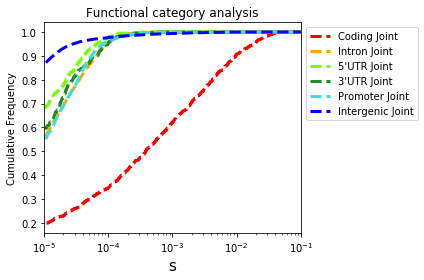

Done
CPU times: user 3.77 s, sys: 47.2 ms, total: 3.81 s
Wall time: 3.89 s


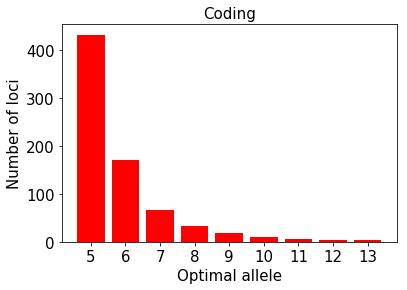

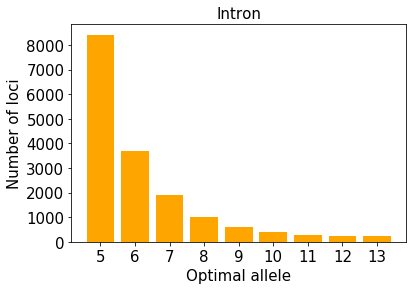

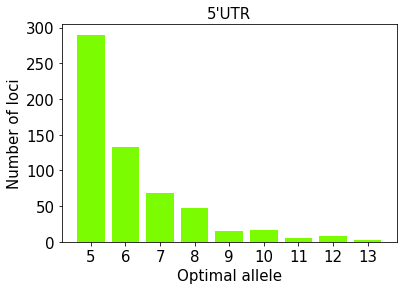

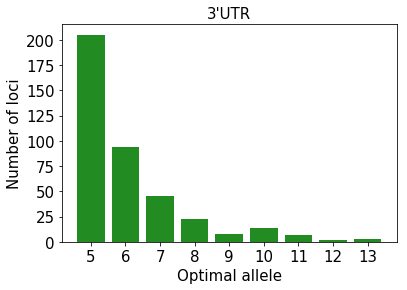

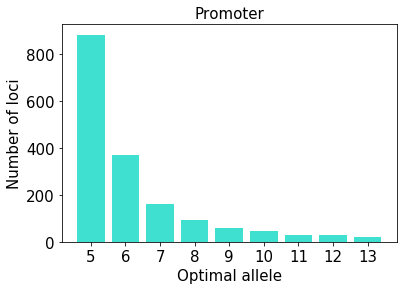

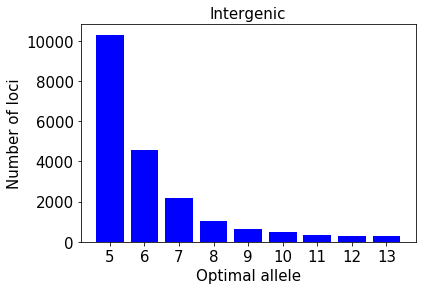

In [17]:
%%time
if __name__ == '__main__':
    main()